# Machine Learning pre-processing workflow

Last week we did some exploratory data analysis (EDA) on the patient data. This is important to already investigate certain patterns in the data (some of which are artefacts, remember FiO2?). EDA is only the beginning, it is necessary to do the next part correct. 

This next part is called pre-processing, signal-processing, or processing depending on who you ask. The aim is to get to the data matrix which we know from the first lesson. This data matrix can then be used for machine learning.


In this lesson you will:

- use your EDA knowledge to clean the data
- extract meaningfull features from the data
- construct the data matrix

## The data
But first, let's discuss the data in a bit more detail:

- the raw signals you know already: HF (Heart Rate), FiO2 (administered oxygen), SpO2 (oxygen saturation), and Taxillair (Temperature).
- There are also metadata. Most are self explanatory. Think about which ones you might also want to include in your final data matrix. p.s. gestational_age is the age at birth in weeks (9 months = ca. 40 weeks).
- the patients are healyth at the start of the data for at least 2 days
- some patients get sick at the end of the data. The last day these patients are definately sick but possibly already longer. 
- which patiets are of the sick type you can find in the End_of_stay_disease.txt file 



## Procedure example

Before we start, let me outline a procedure you can follow which I think is relatively easy. In this way you can build your processing script (and data matrix) part by part. Note, you can also use your own method.

1. You start with 1 patient (at the end we will loop over all patients so keep this in mind when writing your script).
2. Do 1 signal at a time (so start with the heart rate, or FiO2 or whatever.)
3. Clean the signal 
4. calculate metrics/features on this signal (or other derived signals) and add these to an array or initialized matrix. A trivial example of a feature could be: the average heart rate in the last 24 hours. Try to be somewhat creative here.
5. repeat for all signals
6. Think whether you want to include some metadata into your feature matrix
7. if everything calculates correct, write it into a loop and keep track of the outcome (healthy vs disease)

At the end you should have a matrix. How many rows and how many columns will depend on your approach. But try to be clever with the data, can you produce more rows with the data? This will help your machine learning. Also, try to think of different features/metrics that you calculate, the more different they are the more chance you have of getting some crucial patterns

p.s. I showed you an example of how to accumulate features (columns) in an empty matrix, see the flower notebook from the first lesson for that.


## Submission and scoring

At the end you should have a matrix, name your columns and describe each column (each feature), e.g. feat_1 = "average heart rate in the last 24 hours". This way I can see which ones you built without having to figure it out from your code. Please also clean up your notebook and code you submit to me. Keep the dirty version to yourself. 

I will grade you on the follwoing things:
- your code works (test this out, you can assume I have the files in my working directory)
- your notebook is clean and well documented with some text (but no shakespearean novels please)
- you cleaned the data correctly
- your pre processing ideas and execution
- the features you calculate

- you can earn a little extra if you show that you can train a model on your matrix (this way I now your feature matrix and outcome vector are ok), and if you then evaluate the performance on the training data. The actual performance is of no importance, so don't worry should it be bad.

### Import packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime

### Read in the data

In [4]:
meta = pd.read_csv("patient_meta.txt", sep=";")
rawsignals = pd.read_csv("02 Patient Rawsignals.txt", sep=";")
disease = pd.read_csv("End_of_stay_disease.txt", header=None)

# Transform meta data

In [5]:
metaNeeded = meta[["value", "field", "patient_ID"]]
metaNeeded.head()

,value,field,patient_ID
0,34.87,gestational_age,257777778
1,1895,birth_weight,257777778
2,Bed 1,NICU_ID,257777778
3,Aa1,firstname,257777778
4,Bb1,lastname,257777778


In [6]:
metaNeeded = metaNeeded.pivot(index="patient_ID", columns = "field", values="value")
metaNeeded = metaNeeded[["birth_weight", "date_of_birth", "gestational_age"]]
metaNeeded.head()

field,birth_weight,date_of_birth,gestational_age
patient_ID,,,
257777778,1895,2021-08-30 12:00:00,34.87
257777779,1030,2021-08-31 08:00:00,27.77
257777781,0.556,2021-09-07 13:00:00,23.84
257777783,1615,2021-09-13 10:00:00,32.5
257777785,1873,2021-09-20 11:00:00,34.66


# Transform rawsignals data

In [7]:
rawsignals.head()

,time,value,NICU_ID,field,measurement,hospital_ID,patient_ID,signal_type
0,1.630454e+09,171,Bed 1,signal_value,rawsignal,UZA,257777778,HF
1,1.630454e+09,170,Bed 1,signal_value,rawsignal,UZA,257777778,HF
2,1.630454e+09,170,Bed 1,signal_value,rawsignal,UZA,257777778,HF
3,1.630454e+09,170,Bed 1,signal_value,rawsignal,UZA,257777778,HF
4,1.630455e+09,169,Bed 1,signal_value,rawsignal,UZA,257777778,HF


In [8]:
rawsignals = rawsignals[["time", "value", "patient_ID", "signal_type"]]
rawsignals.head()

,time,value,patient_ID,signal_type
0,1.630454e+09,171,257777778,HF
1,1.630454e+09,170,257777778,HF
2,1.630454e+09,170,257777778,HF
3,1.630454e+09,170,257777778,HF
4,1.630455e+09,169,257777778,HF


# Transform disease data

In [9]:
disease.head()

,0
0,257777781
1,257777788
2,257777790
3,257777793
4,257777795


#### Add a true indicator if patient was sick at the end of stay

In [10]:
sickPeople = []
for x in disease.index:
    sick = disease.loc[disease.index == x]
    sickPeople.append(sick.values.item())

In [11]:
sickPeople

[257777781,
 257777788,
 257777790,
 257777793,
 257777795,
 257777796,
 257777798,
 257777803,
 257777804,
 257777805]

In [12]:
metaNeeded["sick"] = "false"

In [13]:
i = 0
while(i < len(sickPeople)):
    metaNeeded.loc[metaNeeded.index == sickPeople[i], "sick"] = "true"
    i+=1

In [14]:
metaNeeded.head()

field,birth_weight,date_of_birth,gestational_age,sick
patient_ID,,,,
257777778,1895,2021-08-30 12:00:00,34.87,false
257777779,1030,2021-08-31 08:00:00,27.77,false
257777781,0.556,2021-09-07 13:00:00,23.84,true
257777783,1615,2021-09-13 10:00:00,32.5,false
257777785,1873,2021-09-20 11:00:00,34.66,false


# Look for missing values

In [15]:
metaNeeded.isnull().sum()

field
birth_weight       0
date_of_birth      0
gestational_age    0
sick               0
dtype: int64

In [16]:
rawsignals.isnull().sum()

time           0
value          0
patient_ID     0
signal_type    0
dtype: int64

# Features patient 1

In [57]:
test_patient = np.unique(metaNeeded.index)[0]
patient_signals = rawsignals.loc[rawsignals['patient_ID'] == test_patient]

In [58]:
patient_signals.tail()

,time,value,patient_ID,signal_type
86454,1.631246e+09,103,257777778,Taxillair
86455,1.631261e+09,97,257777778,Taxillair
86456,1.631275e+09,101,257777778,Taxillair
86457,1.631290e+09,97,257777778,Taxillair
86458,1.631304e+09,100,257777778,Taxillair


## Heart Frequency

In [59]:
test_signals = patient_signals.loc[patient_signals['signal_type'] == "HF"]

In [60]:
test_signals.tail()

,time,value,patient_ID,signal_type
28795,1.631318e+09,184,257777778,HF
28796,1.631318e+09,184,257777778,HF
28797,1.631318e+09,184,257777778,HF
28798,1.631318e+09,184,257777778,HF
28799,1.631318e+09,184,257777778,HF


### Find the mean, median, lowest and highest heart rate

In [61]:
meanHF = np.mean(test_signals['value'])
highHF = np.max(test_signals['value'])
lowHF = np.min(test_signals['value'])
HF_values = [meanHF, highHF,lowHF]

In [62]:
print("Average heart frequency measured:", round(meanHF, 2))
print("Highest heart frequency measured:", highHF)
print("Lowest heart frequency measured:", lowHF)

Average heart frequency measured: 176.57
Highest heart frequency measured: 206
Lowest heart frequency measured: 79


### Plot of first day

In [40]:
patient_first_day = np.min(test_signals['time']) + 24 * 60
patient_first_day 

1630455850.0

In [41]:
test_signals.loc[test_signals['time'] == 1630455850.0]

,time,value,patient_ID,signal_type
48,1.630456e+09,175,257777778,HF


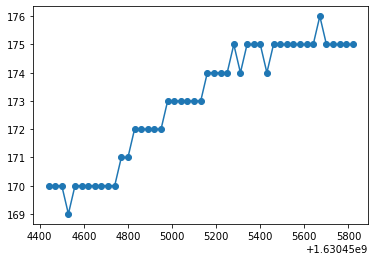

In [42]:
test_plot = test_signals.iloc[1:48]
plt.plot(test_plot['time'], test_plot['value'])
plt.scatter(test_plot['time'], test_plot['value'])

### Plot of last day

In [43]:
patient_last_day = np.max(test_signals['time'])
patient_last_start = patient_last_day - 24 * 60 
print(patient_last_day, patient_last_start)

1631318380.0 1631316940.0


In [44]:
test_signals.loc[test_signals['time'] == 1631316940.0]

,time,value,patient_ID,signal_type
28751,1.631317e+09,188,257777778,HF


In [45]:
test_signals.loc[test_signals['time'] == 1631318380.0]

,time,value,patient_ID,signal_type
28799,1.631318e+09,184,257777778,HF


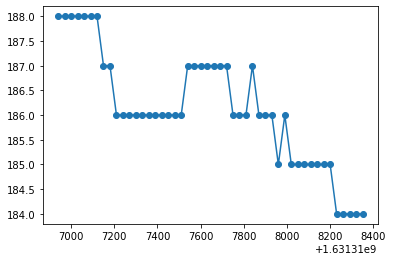

In [46]:
test_plot_last = rawsignals.iloc[28751:28799]
plt.plot(test_plot_last['time'], test_plot_last['value'])
plt.scatter(test_plot_last['time'], test_plot_last['value'])

## Number of days in the hospital

In [47]:
inHospital = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(np.min(test_signals['time'])))
outHospital = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(np.max(test_signals['time'])))

In [48]:
startdate = datetime.strptime(inHospital, '%Y-%m-%d %H:%M:%S')
enddate = datetime.strptime(outHospital, '%Y-%m-%d %H:%M:%S')
roundDateStart = startdate.replace(hour=0, minute=0, second=0, microsecond=0)
roundDateEnd = enddate.replace(hour=0, minute=0, second=0, microsecond=0)

In [49]:
daysInHospital = (roundDateEnd - roundDateStart).days

In [50]:
print(roundDateStart)
print(enddate)
print(daysInHospital)

2021-09-01 00:00:00
2021-09-11 01:59:40
10


## FiO2

In [340]:
FIO_signals = patient_signals.loc[patient_signals['signal_type'] == "FiO2"]

In [341]:
FIO_signals.head()

,time,value,patient_ID,signal_type
57600,1.630454e+09,21,257777778,FiO2
57601,1.630454e+09,21,257777778,FiO2
57602,1.630455e+09,21,257777778,FiO2
57603,1.630455e+09,21,257777778,FiO2
57604,1.630455e+09,21,257777778,FiO2


### Find the mean, median, lowest and highest FiO2

In [342]:
meanFIO = np.mean(FIO_signals['value'])
highFIO = np.max(FIO_signals['value'])
lowFIO = np.min(FIO_signals['value'])

In [343]:
print("Average FiO2 measured:", round(meanFIO, 2))
print("Highest FiO2 measured:", highFIO)
print("Lowest FiO2 measured:", lowFIO)

Average FiO2 measured: 30.42
Highest FiO2 measured: 100
Lowest FiO2 measured: 21


In [344]:
highest_value = FIO_signals.loc[FIO_signals["value"] == 100]
highest_value["patient_ID"].count()

51

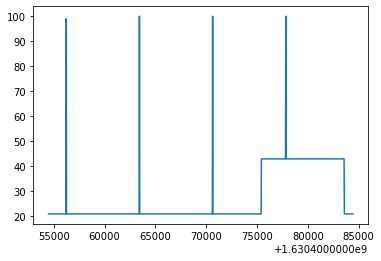

In [345]:
# FiO2_sub = FIO_signals.loc[FIO_signals['value'] < 98]  
# plt.plot(FiO2_sub['time'], FiO2_sub['value'])
FiO2_sub = FIO_signals.iloc[1:1000]  
plt.plot(FiO2_sub['time'], FiO2_sub['value'])

## SpO2

In [346]:
SPO2_signals = patient_signals.loc[patient_signals['signal_type'] == "SpO2"]
SPO2_signals.head()

,time,value,patient_ID,signal_type
28800,1.630454e+09,89,257777778,SpO2
28801,1.630454e+09,89,257777778,SpO2
28802,1.630454e+09,89,257777778,SpO2
28803,1.630455e+09,89,257777778,SpO2
28804,1.630455e+09,90,257777778,SpO2


### Find the mean, median, lowest and highest SpO2

In [347]:
meanSPO2 = np.mean(SPO2_signals['value'])
highSPO2 = np.max(SPO2_signals['value'])
lowSPO2 = np.min(SPO2_signals['value'])

In [348]:
print("Average FiO2 measured:", round(meanSPO2, 2))
print("Highest FiO2 measured:", highSPO2)
print("Lowest FiO2 measured:", lowSPO2)

Average FiO2 measured: 79.0
Highest FiO2 measured: 100
Lowest FiO2 measured: 30


In [349]:
lowest_value = SPO2_signals.loc[SPO2_signals["value"] == 30]
lowest_value["patient_ID"].count()

6

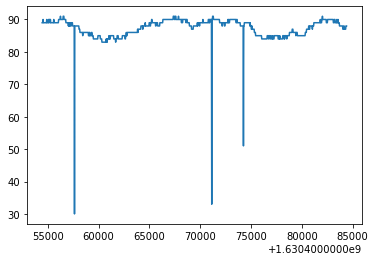

In [350]:
SPO2_sub = SPO2_signals.iloc[1:1000]
plt.plot(SPO2_sub['time'], SPO2_sub['value'])

## Taxillair

In [351]:
Tax_signals = patient_signals.loc[patient_signals['signal_type'] == "Taxillair"]
Tax_signals.head()

,time,value,patient_ID,signal_type
86399,1.630454e+09,97,257777778,Taxillair
86400,1.630469e+09,99,257777778,Taxillair
86401,1.630483e+09,98,257777778,Taxillair
86402,1.630498e+09,103,257777778,Taxillair
86403,1.630512e+09,97,257777778,Taxillair


### Find the mean, median, lowest and highest SpO2

In [352]:
meanTax = np.mean(Tax_signals['value'])
highTax = np.max(Tax_signals['value'])
lowTax = np.min(Tax_signals['value'])

In [353]:
print("Average FiO2 measured:", round(meanTax, 2))
print("Highest FiO2 measured:", highTax)
print("Lowest FiO2 measured:", lowTax)

Average FiO2 measured: 99.87
Highest FiO2 measured: 104
Lowest FiO2 measured: 97


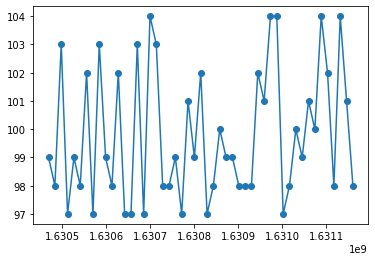

In [354]:
T_sub = Tax_signals.iloc[1:50]
plt.plot(T_sub['time'], T_sub['value'])
plt.scatter(T_sub['time'], T_sub['value'])

# Making the data matrix

In [382]:
HF_Sum_results = np.empty((0, 3), float)
Days_Sum_results = np.empty((0, 1), int)
FiO2_Sum_results = np.empty((0, 3), float)
SpO2_Sum_results = np.empty((0, 3), float)
Taxillair_Sum_results = np.empty((0, 3), float)
birth_weight_results = np.empty((0, 1), float)
date_of_birth_results = np.empty((0, 1), str)
gestational_age_results = np.empty((0, 1), float)
sick_results = np.empty((0, 1), str)

In [394]:
idx = 0
while(idx < 23):
    #unique patients
    patientid = np.unique(metaNeeded.index)[idx]
    patients_signals = rawsignals.loc[rawsignals['patient_ID'] == patientid]
    #for HF
    HFsignals = patients_signals.loc[patients_signals['signal_type'] == "HF"]
    meanHF = np.mean(HFsignals['value'])
    highHF = np.max(HFsignals['value'])
    lowHF = np.min(HFsignals['value'])
    totals = [[meanHF, highHF, lowHF]]
    HF_Sum_results = np.append(HF_Sum_results, totals, axis = 0)
    
    #days in hospital
    inHospital = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(np.min(patients_signals['time'])))
    outHospital = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(np.max(patients_signals['time'])))
    
    startdate = datetime.strptime(inHospital, '%Y-%m-%d %H:%M:%S')
    enddate = datetime.strptime(outHospital, '%Y-%m-%d %H:%M:%S')
    roundDateStart = startdate.replace(hour=0, minute=0, second=0, microsecond=0)
    roundDateEnd = enddate.replace(hour=0, minute=0, second=0, microsecond=0)
    
    daysInHospital = (roundDateEnd - roundDateStart).days
    totalDays = [[daysInHospital]]
    Days_Sum_results = np.append(Days_Sum_results, totalDays, axis = 0)
    
    #FiO2 
    FIsignals = patients_signals.loc[patients_signals['signal_type'] == "FiO2"]
    meanFI = np.mean(FIsignals['value'])
    highFI = np.max(FIsignals['value'])
    lowFI = np.min(FIsignals['value'])
    totalFI = [[meanFI, highFI, lowFI]]
    FiO2_Sum_results = np.append(FiO2_Sum_results, totalFI, axis = 0)
    
    #SpO2
    SPsignals = patients_signals.loc[patients_signals['signal_type'] == "SpO2"]
    meanSP = np.mean(SPsignals['value'])
    highSP = np.max(SPsignals['value'])
    lowSP = np.min(SPsignals['value'])
    totalSP = [[meanSP, highSP, lowSP]]
    SpO2_Sum_results = np.append(SpO2_Sum_results, totalSP, axis = 0)
    
    #Taxillair
    TaxSignals = patients_signals.loc[patients_signals['signal_type'] == "Taxillair"]
    meanTax = np.mean(TaxSignals['value'])
    highTax = np.max(TaxSignals['value'])
    lowTax = np.min(TaxSignals['value'])
    totalTax = [[meanTax, highTax, lowTax]]
    Taxillair_Sum_results = np.append(Taxillair_Sum_results, totalTax, axis = 0)

    idx+=1

In [415]:
for index, row in metaNeeded.iterrows():
    birth_weight_results  = np.append(birth_weight_results, [[row['birth_weight']]], axis = 0)
    date_of_birth_results  = np.append(date_of_birth_results, [[row['date_of_birth']]], axis = 0)
    gestational_age_results  = np.append(gestational_age_results, [[row['gestational_age']]], axis = 0)
    sick_results  = np.append(sick_results, [[row['sick']]], axis = 0)

In [416]:
HF_Sum_results

array([[176.5703125 , 206.        ,  79.        ],
       [214.42756944, 256.        ,  82.        ],
       [199.70670139, 232.        ,  80.        ],
       [160.20114583, 438.        ,  62.        ],
       [126.53604167, 173.        ,  44.        ],
       [194.24465278, 226.        ,  84.        ],
       [203.63774306, 235.        ,  89.        ],
       [132.77333333, 180.        ,  51.        ],
       [134.42805556, 163.        ,  57.        ],
       [164.13753472, 198.        ,  69.        ],
       [152.09524306, 175.        ,  64.        ],
       [128.72090278, 414.        ,  47.        ],
       [153.99097222, 191.        ,  58.        ],
       [146.21402778, 175.        ,  57.        ],
       [145.18861111, 173.        ,  52.        ],
       [160.43802083, 416.        ,  62.        ],
       [166.87854167, 195.        ,  70.        ],
       [136.26270833, 425.        ,  55.        ],
       [125.30038194, 169.        ,  48.        ],
       [148.90427083, 182.     

In [417]:
Days_Sum_results

array([[10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10],
       [10]])

In [418]:
FiO2_Sum_results

array([[ 30.42015348, 100.        ,  21.        ],
       [ 30.36008195, 100.        ,  21.        ],
       [ 32.7862773 , 100.        ,  21.        ],
       [ 31.42886906, 100.        ,  21.        ],
       [ 30.36035973, 100.        ,  21.        ],
       [ 32.14590784, 100.        ,  21.        ],
       [ 29.88989201, 100.        ,  21.        ],
       [ 32.92614327, 100.        ,  21.        ],
       [ 29.99583319, 100.        ,  21.        ],
       [ 29.26532171, 100.        ,  21.        ],
       [ 29.52609466, 100.        ,  21.        ],
       [ 31.20691691, 100.        ,  21.        ],
       [ 31.16101254, 100.        ,  21.        ],
       [ 32.56811   , 100.        ,  21.        ],
       [ 31.60255564, 100.        ,  21.        ],
       [ 30.01406299, 100.        ,  21.        ],
       [ 32.14552589, 100.        ,  21.        ],
       [ 29.8642314 , 100.        ,  21.        ],
       [ 30.93572693, 100.        ,  21.        ],
       [ 30.36942255, 100.     

In [419]:
SpO2_Sum_results

array([[ 79.00309028, 100.        ,  30.        ],
       [ 99.52194444, 100.        ,  30.        ],
       [ 82.12461806, 100.        ,  30.        ],
       [ 66.39302083,  96.        ,  30.        ],
       [ 98.44211806, 100.        ,  30.        ],
       [ 95.29861111, 100.        ,  31.        ],
       [ 72.01111111,  96.        ,  31.        ],
       [ 62.53392361,  92.        ,  30.        ],
       [ 97.26538194, 100.        ,  30.        ],
       [ 68.05409722, 100.        ,  30.        ],
       [ 95.88100694, 100.        ,  30.        ],
       [ 74.93607639,  93.        ,  30.        ],
       [ 69.47621528,  91.        ,  30.        ],
       [ 90.70440972, 100.        ,  30.        ],
       [ 88.25958333, 100.        ,  30.        ],
       [ 80.44826389, 100.        ,  30.        ],
       [ 93.71954861, 100.        ,  30.        ],
       [ 84.09850694, 100.        ,  30.        ],
       [ 98.40697917, 100.        ,  30.        ],
       [ 59.15472222,  97.     

In [420]:
Taxillair_Sum_results

array([[ 99.86666667, 104.        ,  97.        ],
       [100.46666667, 104.        ,  97.        ],
       [100.26666667, 104.        ,  97.        ],
       [100.26666667, 104.        ,  97.        ],
       [100.5       , 104.        ,  97.        ],
       [100.4       , 104.        ,  97.        ],
       [100.7       , 104.        ,  97.        ],
       [100.6       , 104.        ,  97.        ],
       [100.75      , 104.        ,  97.        ],
       [100.58333333, 104.        ,  97.        ],
       [101.21666667, 104.        ,  97.        ],
       [100.4       , 104.        ,  97.        ],
       [100.98333333, 104.        ,  97.        ],
       [100.86666667, 104.        ,  97.        ],
       [100.36666667, 104.        ,  97.        ],
       [100.3       , 104.        ,  97.        ],
       [100.58333333, 104.        ,  97.        ],
       [100.06666667, 104.        ,  97.        ],
       [100.8       , 104.        ,  97.        ],
       [100.55      , 104.     

In [421]:
birth_weight_results

array([['1895'],
       ['1895'],
       ['1030'],
       ['0.556'],
       ['1615'],
       ['1873'],
       ['714'],
       ['1125'],
       ['721'],
       ['795'],
       ['1585'],
       ['1130'],
       ['582'],
       ['486'],
       ['1897'],
       ['1388'],
       ['896'],
       ['1908'],
       ['1.773'],
       ['1895'],
       ['556'],
       ['1357'],
       ['1162'],
       ['980']], dtype='<U32')

In [422]:
date_of_birth_results

array([['2021-08-30 12:00:00'],
       ['2021-08-31 08:00:00'],
       ['2021-09-07 13:00:00'],
       ['2021-09-13 10:00:00'],
       ['2021-09-20 11:00:00'],
       ['2021-09-22 14:00:00'],
       ['2021-09-25 03:00:00'],
       ['2021-09-27 05:00:00'],
       ['2021-10-02 07:00:00'],
       ['2021-10-04 21:00:00'],
       ['2021-10-10 14:00:00'],
       ['2021-10-13 23:00:00'],
       ['2021-10-19 11:00:00'],
       ['2021-10-22 16:00:00'],
       ['2021-10-28 13:00:00'],
       ['2021-10-31 15:00:00'],
       ['2021-11-03 16:00:00'],
       ['2021-11-05 22:00:00'],
       ['2021-11-08 19:00:00'],
       ['2021-11-12 15:00:00'],
       ['2021-11-16 08:00:00'],
       ['2021-11-18 10:00:00'],
       ['2021-11-25 06:00:00']], dtype='<U19')

In [423]:
gestational_age_results

array([['34.87'],
       ['27.77'],
       ['23.84'],
       ['32.5'],
       ['34.66'],
       ['24.99'],
       ['28.51'],
       ['25.06'],
       ['25.78'],
       ['32.27'],
       ['28.44'],
       ['24.02'],
       ['23.1'],
       ['34.83'],
       ['30.67'],
       ['26.54'],
       ['34.96'],
       ['33.87'],
       ['34.86'],
       ['23.79'],
       ['30.52'],
       ['28.89'],
       ['27.35']], dtype='<U32')

In [424]:
sick_results

array([['false'],
       ['false'],
       ['true'],
       ['false'],
       ['false'],
       ['false'],
       ['false'],
       ['true'],
       ['false'],
       ['true'],
       ['false'],
       ['true'],
       ['true'],
       ['true'],
       ['true'],
       ['false'],
       ['false'],
       ['false'],
       ['false'],
       ['true'],
       ['true'],
       ['true'],
       ['false']], dtype='<U5')